In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import math
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline

In [2]:
ip = ImagePipeline(input_color='bgr')
ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
mtx = ip.mtx
dist = ip.dist

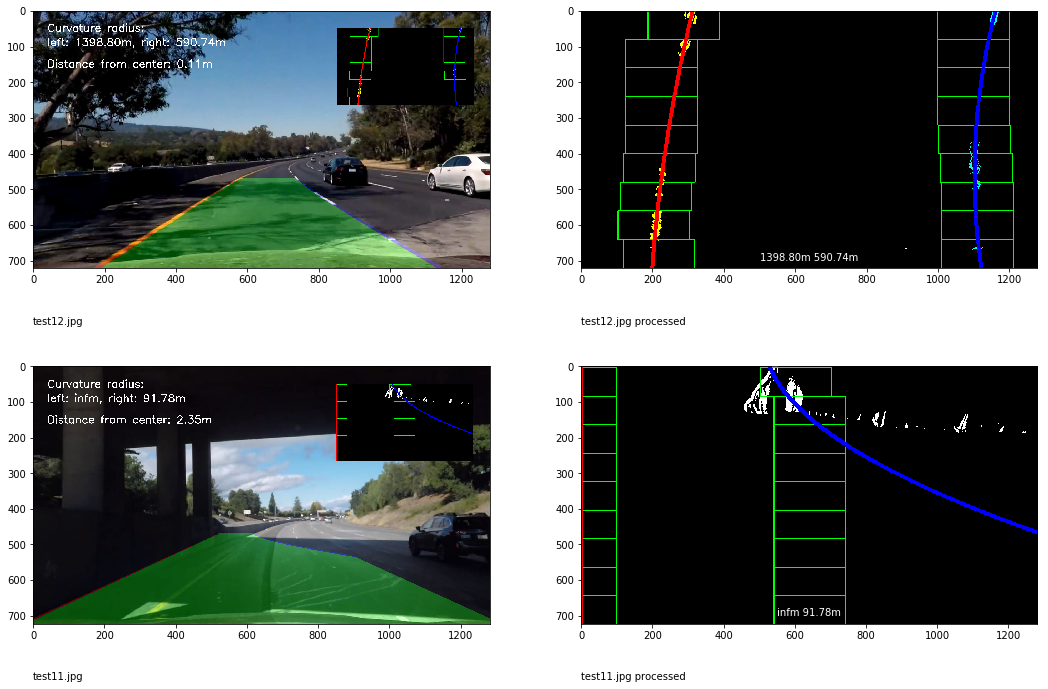

In [3]:
def adjust_thresholds(change=None):
    """
    combiner values: "dir", "mag", None
    """
    r=r_i.value
    g=g_i.value
    b=b_i.value
    h=h_i.value
    l=l_i.value
    s=s_i.value
    y=y_i.value
    u=u_i.value
    v=v_i.value
    h2=h2_i.value
    s2=s2_i.value
    v2=v2_i.value
    sobel_x=sobel_x_i.value
    sobel_y=sobel_y_i.value
    sobel_x_kernel=sobel_y_i.value
    sobel_y_kernel=sobel_y_kernel_i.value
    combiner=combiner_i.value
    mag_or_sobel_range=mag_or_sobel_range_i.value
    dir_range=dir_range_i.value
    edge_only=edge_only_i.value
    show_annotations=show_annotations_i.value
    
    ip = ImagePipeline(input_color='bgr')
    # ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
    ip.mtx = mtx
    ip.dist = dist

    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])

    dst = np.float32([[ 120.,  720.],
                      [ 120.,    0.],
                      [ 1160.,    0.],
                      [ 1160.,  720.]])

    ip.set_perspective(src, dst)
            
    if combiner == 'dir':
        t = Threshold(trange=dir_range, crop_b=50)
    else:
        t = Threshold(trange=mag_or_sobel_range, crop_b=50)
        
    cc = []
    if r:
        cc.append('r')
    if g:
        cc.append('g')
    if b:
        cc.append('b')
    if h:
        cc.append('h')
    if l:
        cc.append('l')
    if s:
        cc.append('s')
    if y:
        cc.append('y')
    if u:
        cc.append('u')
    if v:
        cc.append('v')
    if h2:
        cc.append('h2')
    if s2:
        cc.append('s2')
    if v2:
        cc.append('v2')
        
    t.add(Color(cc))
    
    if sobel_x:
        t.add(Sobel('x', kernel=sobel_x_kernel))
    
    if sobel_y:
        t.add(Sobel('y', kernel=sobel_y_kernel))
        
    if combiner == 'dir':
        t.add(Direction())
    elif combiner == 'mag':
        t.add(Magnitude())
            
    ip.add(t)
    
    if not edge_only:
        t1 = Threshold(trange=(1, 255), crop_b=50)
        t1.add(Color(['h', 'l', 's'], in_range=((20, 100, 12), (138, 255, 255))))
        ip.add(t1)

        t2 = Threshold(trange=(1, 255), crop_b=50)
        t2.add(Color(['h', 'l', 's'], in_range=((0, 202, 0), (255, 255, 255))))
        ip.add(t2)

        c = Combinator(f=(lambda ths: np.where(
            ((ths[1] == 1) | (ths[2] == 1)) & ths[0]
        )))
    else:
        c = Combinator(f=(lambda ths: np.where((ths[0] == 1))))
        
    ip.add(c)
    f = FindLinesSlidingWindows(always_recalculate=True)
    ip.add(f)
    
    a = Annotate(f)
    ip.add(a)
    
#     all_images = glob.glob('test_images/*.jpg')
#     img_paths = all_images[:]
    img_paths = ['test_images/test12.jpg', 'test_images/test11.jpg']

    cols = 2
    rows = math.ceil(float(len(img_paths))/cols)*2
    fig = plt.figure(figsize=(18, 6*rows))
    i = 0
    for fname in img_paths:
        name = os.path.basename(fname)
        img = cv2.imread(fname)
        processed = ip.process(img)
        
        ax = fig.add_subplot(rows, cols, i+1)
        plt.imshow(processed)
        plt.text(0, 880, name)
        i+=1
        
        ax = fig.add_subplot(rows, cols, i+1)
        if show_annotations:
            plt.imshow(a.map)
        else:
            plt.imshow(c.img, cmap='gray')

        plt.text(0, 880, "{} processed".format(name))
        plt.text(640, 700, "{:.2f}m {:.2f}m".format(f.left_curverad_m, f.right_curverad_m), color='white', ha='center')
        i+=1
    clear_output(True)


r_i = Checkbox(description='r', value=False)
g_i = Checkbox(description='g', value=False)
b_i = Checkbox(description='b', value=False)
h_i = Checkbox(description='h', value=False)
l_i = Checkbox(description='l', value=False)
s_i = Checkbox(description='s', value=True)
y_i = Checkbox(description='y', value=False)
u_i = Checkbox(description='u', value=False)
v_i = Checkbox(description='v', value=False)
h2_i = Checkbox(description='h2', value=False)
s2_i = Checkbox(description='s2', value=False)
v2_i = Checkbox(description='v2', value=False)
sobel_x_i = Checkbox(description='sobel x', value=False)
sobel_y_i = Checkbox(description='sobel y', value=True)
sobel_x_kernel_i = IntSlider(description='sobel x kernel', min=1, max=31, step=2, value=3)
sobel_y_kernel_i = IntSlider(description='sobel y kernel', min=1, max=31, step=2, value=15)
combiner_i = RadioButtons(description='combiner', options=[None, 'mag', 'dir'], value='mag')
mag_or_sobel_range_i = IntRangeSlider(description='mag or sobel range', min=0, max=512, step=1, value=[4, 161])
dir_range_i = FloatRangeSlider(description='dir range', min=0, max=np.pi / 2, step=0.01,value=[0.7, 1.3])
edge_only_i = Checkbox(description='edge threshold only', value=False)
show_annotations_i = Checkbox(description='show annotations', value=True)

r_i.observe(adjust_thresholds, 'value')
g_i.observe(adjust_thresholds, 'value')
b_i.observe(adjust_thresholds, 'value')
h_i.observe(adjust_thresholds, 'value')
l_i.observe(adjust_thresholds, 'value')
s_i.observe(adjust_thresholds, 'value')
y_i.observe(adjust_thresholds, 'value')
u_i.observe(adjust_thresholds, 'value')
v_i.observe(adjust_thresholds, 'value')
h2_i.observe(adjust_thresholds, 'value')
s2_i.observe(adjust_thresholds, 'value')
v2_i.observe(adjust_thresholds, 'value')
sobel_x_i.observe(adjust_thresholds, 'value')
sobel_y_i.observe(adjust_thresholds, 'value')
sobel_x_kernel_i.observe(adjust_thresholds, 'value')
sobel_y_kernel_i.observe(adjust_thresholds, 'value')
combiner_i.observe(adjust_thresholds, 'value')
mag_or_sobel_range_i.observe(adjust_thresholds, 'value')
dir_range_i.observe(adjust_thresholds, 'value')
edge_only_i.observe(adjust_thresholds, 'value')
show_annotations_i.observe(adjust_thresholds, 'value')

display(r_i, g_i, b_i, h_i, l_i, s_i, y_i, u_i, v_i, h2_i, s2_i, v2_i,
        sobel_x_i, sobel_y_i, sobel_x_kernel_i, sobel_y_kernel_i, combiner_i,
        mag_or_sobel_range_i, dir_range_i, edge_only_i, show_annotations_i)
adjust_thresholds()